In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify 

In [2]:
year = 2020
color = ['red','blue','green','yellow']
states_dict = {'Rakousko':'AT', 
               'Belgie':'BE', 
               'Bulharsko':'BG',
               'Kypr':'CY',
               'České Republika':'CZ',
               'Německo':'DE',
               'Dánsko':'DK',
               'Estonsko':'EE',
               'Špenělsko':'ES',
               'Finsko':'FI',
               'Francie':'FR',
               'Chorvatsko':'HR',
               'Maďarsko':'HU',
               'Irsko':'IE',
               'Itálie':'IT',
               'Litva':'LT',
               'Lucembursko':'LU',
               'Lotyšsko':'LV',
               'Malta':'MT',
               'Nizozemsko':'NL',
               'Polsko':'PL',
               'Portugalsko':'PT',
               'Rumunsko':'RO',
               'Švédsko':'SE',
               'Slovinsko':'SI',
               'Slovensko':'SK',}

Načti a uprav dataframy

In [3]:
# Emise
df_sorce_emis = eurostat.get_data_df('env_air_gge')
df_emis = df_sorce_emis.rename(columns={'geo\\time': 'geo'})
df_emis = df_emis.query("src_crf == 'TOTX4_MEMONIA' and unit == 'MIO_T' and airpol == 'GHG'")

In [4]:
# Demografie
df_sorce_demo = eurostat.get_data_df('demo_pjan')
df_demo = df_sorce_demo.rename(columns={'geo\\time': 'geo'})
df_demo = df_demo.query("age == 'TOTAL' and sex == 'T'")

df_demo = df_demo.loc[df_demo['geo'].isin(states_dict.values())]
df_demo = df_demo[["geo", year]]

In [5]:
# Emise
df_new = pd.DataFrame()
for item in df_emis['geo']:
    if item in states_dict.values():
        df_new = df_new.append(df_emis.loc[df_emis['geo'] == item])

df_emis = df_new[["geo", year]]

Spoj dataframy

In [7]:
df_merged = df_emis.merge(df_demo, on='geo') # tohle by měl být inner join - zeptat se Fandy
df_merged.rename(columns = {f'{year}_x':f'{year}_emis', f'{year}_y':f'{year}_popul'}, inplace = True)

Emise na obyvatele, název státu (nové sloupce do df a jejich úprava)

In [8]:
df_merged['em_na_oby'] = (df_merged[f'{year}_emis'] * 1000000) / df_merged[f'{year}_popul']
df_merged['stat'] = states_dict.keys()
df_merged = df_merged.set_index('stat')
df_merged = df_merged.sort_values(f'{year}_emis', ascending = False)

Kresli grafy

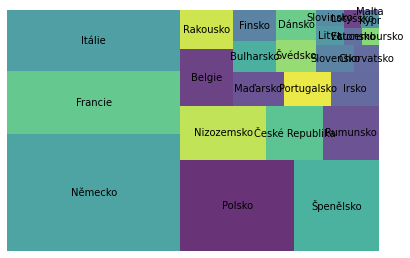

In [9]:
# Jak hodit Německo do levýho horního rohu? a musí to tak bejt?
squarify.plot(df_merged[f'{year}_emis'], label=df_merged.index, alpha=0.8)
plt.axis("off")
plt.show()

In [10]:
# Jak hodit hodnoty CO2 do sloupečků?

Text(0, 0.5, '')

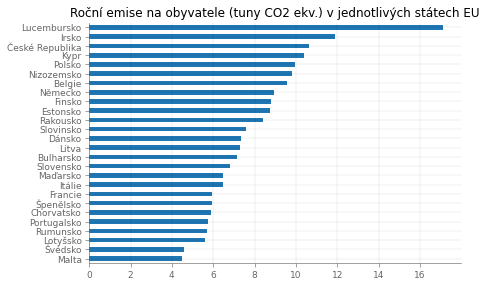

In [11]:
# for creating horizontal bar chatr use plot.barh()
df_merged['em_na_oby'].sort_values().plot.barh(title='Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU')
plt.ylabel('')

Jiné možná někdy dál užitečné

In [12]:
# df_demo_sorce['sex'].unique()